In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import power_transform
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [2]:
# reading the data
cdp_summary = pd.read_stata("../../data/CDP Cleaning/cleaned outputs/cdp_summary.dta").replace("", pd.NA)

Total Number Of Frim Years and total number of unique firms.

In [3]:
# number of rows and columns
cdp_summary.shape

(34588, 10)

In [4]:
# number of unique firm ids
len(cdp_summary['id'].unique())

11289

In [5]:
cdp_summary.loc[cdp_summary['companyname'] == 'Jetblue Airways Corporation']

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate
8766,9759,financial control,2018.0,Jetblue Airways Corporation,USA,Transportation services,US4771431016,JBLU US,<NA>,2018-08-31
8767,9759,financial control,2019.0,Jetblue Airways Corporation,USA,Transportation services,US4771431016,JBLU US,<NA>,2019-07-31
8768,9759,financial control,2020.0,Jetblue Airways Corporation,USA,Transportation services,US4771431016,JBLU US,<NA>,2020-08-26
8769,9759,financial control,2021.0,Jetblue Airways Corporation,USA,Transportation services,US4771431016,JBLU US,<NA>,2021-08-17
8770,9759,financial control,2022.0,Jetblue Airways Corporation,USA,Transportation services,US4771431016,JBLU US,<NA>,2022-08-01


In [6]:
# do a mapping of id and isin
id_isin = cdp_summary[["id", "isin"]].drop_duplicates()

There are some firms who have multiple isins, I will create a mappnig between firms and isins to make sure that any Isin can be used to match a firm.

In [7]:
id_isin['id'].value_counts().head(10)

id
22499    5
20712    4
21459    4
8054     4
14820    4
11853    4
7616     4
15981    3
9411     3
59242    3
Name: count, dtype: int64

In [8]:
cdp_summary.groupby("id")['isin'].nunique().value_counts()

isin
0    6895
1    4098
2     268
3      23
4       4
5       1
Name: count, dtype: int64

Roughly 30% of the firm-years have missin isins.

In [9]:
cdp_summary['isin'].isna().mean()

0.2907366716780386

Identifying the problem: some firms have multiple ISINS because they change isin over time.

What if I can map ISIN from the beginning through the mapping table? To check.

In [10]:
# Step 1: Group by 'id' and calculate unique 'isin' counts per 'id'
unique_isin_counts = cdp_summary.groupby("id")['isin'].nunique()

# Step 2: Filter IDs that have exactly 4 unique 'isin' values
ids_with_4_isins = unique_isin_counts[unique_isin_counts == 4].index

# Step 3: Use these IDs to locate rows in the original DataFrame
rows_with_4_isins = cdp_summary[cdp_summary['id'].isin(ids_with_4_isins)]


rows_with_4_isins.head(20)

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate
6852,7616,<NA>,2010.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6853,7616,<NA>,2011.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6854,7616,<NA>,2012.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,NaT
6855,7616,<NA>,2013.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,2013-06-28
6856,7616,<NA>,2014.0,Google Inc.,USA,<NA>,US38259P5089,GOOG US,software services,2014-06-10
6857,7616,<NA>,2015.0,Google Inc.,USA,<NA>,US38259P7069,GOOG US,software services,2015-06-30
6858,7616,<NA>,2016.0,"Alphabet, Inc.",USA,Services,US02079K1079,GOOG US,software services,2016-07-25
6859,7616,<NA>,2017.0,"Alphabet, Inc.",USA,Services,US02079K1079,GOOG US,software services,2017-07-15
6860,7616,operational control,2018.0,"Alphabet, Inc.",USA,Services,US02079K1079,"GOOG US, GOOGL US",software services,2018-09-13
6861,7616,operational control,2019.0,"Alphabet, Inc.",USA,Services,US02079K1079,"GOOG US, GOOGL US",software services,2019-08-29


In [11]:
# Assuming 'date_column' is the name of your date or timestamp column
# Step 1: Identify the most recent 'isin' for each 'id'
# Sort the DataFrame by 'id' and 'date_column' in descending order
cdp_summary_sorted = cdp_summary.sort_values(by=['id', 'year'], ascending=[True, False])

# Drop duplicates based on 'id', keeping the first (most recent) occurrence
recent_isin_per_id = cdp_summary_sorted.drop_duplicates(subset='id', keep='first')[['id', 'isin']]

# Step 2: Update all rows to use the most recent 'isin' for each 'id'
# Merge the most recent 'isin' back onto the original DataFrame, based on 'id'
cdp_summary_updated = cdp_summary.merge(recent_isin_per_id, on='id', suffixes=('', '_recent'))

# Replace old 'isin' values with the most recent ones
cdp_summary_updated['isin'] = cdp_summary_updated['isin_recent']

# Drop the temporary 'isin_recent' column
cdp_summary_updated.drop(columns=['isin_recent'], inplace=True)

# cdp_summary_updated now has all rows updated to the most recent 'isin' for each 'id'
cdp_summary = cdp_summary_updated

In [12]:
cdp_summary.groupby("id")['isin'].nunique().value_counts()

isin
0    6959
1    4330
Name: count, dtype: int64

In [13]:
# number of unique fimrs
len(cdp_summary['id'].unique())

11289

In [14]:
# number of firm years without an isin
cdp_summary['isin'].isna().sum()

9785

In [15]:
# number of firm years without an isin 
(cdp_summary.groupby('id')['isin'].sum() == 0).sum()

6959

In [16]:
# dropping the firm years without an isin
cdp_summary = cdp_summary[cdp_summary['isin'].notna()]

In [17]:
cdp_summary.shape

(24803, 10)

In [18]:
# unique firm ids length
len(cdp_summary['id'].unique())

4330

In [19]:
# creating an id_year_isin_mapping
id_year_isin_mapping = cdp_summary[['id', 'year', 'isin']]

In [20]:
# checking for duplicates
id_year_isin_mapping

,id,year,isin
0,44,2011.0,GB00B1YW4409
1,44,2012.0,GB00B1YW4409
2,44,2013.0,GB00B1YW4409
3,44,2014.0,GB00B1YW4409
4,44,2016.0,GB00B1YW4409
...,...,...,...
34550,895420,2022.0,KYG2R55E1030
34552,895480,2022.0,US6031581068
34564,895556,2022.0,US53960E1064
34572,895582,2022.0,MYL5211OO007


In [21]:
id_year_isin_mapping.groupby(['id']).isin.nunique().value_counts()

isin
1    4330
Name: count, dtype: int64

In [22]:
# drop rows where isin == "NA"
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != "NA"]

# drop the value 0 and ""
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != 0]
id_year_isin_mapping = id_year_isin_mapping[id_year_isin_mapping['isin'] != ""]

In [23]:
len(id_year_isin_mapping['isin'].unique())

4302

In [24]:
id_year_isin_mapping['isin'].unique()

array(['GB00B1YW4409', 'ES0111845014', 'US0009571003', ...,
       'US53960E1064', 'MYL5211OO007', 'US04206A1016'], dtype=object)

In [25]:
# preparing the data for wrds query
unique_isin_series = id_year_isin_mapping['isin'].unique()

# Open a text file in write mode
with open('unique_isin_values.txt', 'w') as file:
    for isin in unique_isin_series:
        file.write(f"{isin}\n")  # Write each ISIN followed by a newline

In [26]:
# read financial.csv
financial = pd.read_csv("../../data/raw/financial_v2.csv")

In [27]:
financial.columns

Index(['code', 'year_', 'freq', 'ITEM7011', 'ITEM7210', 'ITEM7220', 'ITEM7230',
       'ITEM7240', 'ITEM7250', 'ITEM8301', 'ITEM8601', 'ITEM8621', 'ITEM8626',
       'ITEM8630', 'ITEM8636', 'ITEM6001', 'ITEM6008', 'ITEM6011'],
      dtype='object')

In [28]:
colnames = ['code', 'year', 'freq', 'employees', 'mkt cap', 'common equity',
       'tot assets', 'revenue', 'net income', 'roe', 'eps 1yr gr', 'assets 1y gr',
        'employees 1y gr', 'employees 5y gr', 'net income 1y gr', 'name', 'isin', 'sector']

In [29]:
financial.columns = colnames

In [30]:
financial['isin'].unique().shape

(4215,)

There are 186 firms without wrds data

- there also seem to be 99 isins that I dropped but that still are in refinitiv, it might be the case that those isins where changed to a later one, or that the new one is not registered yet
- i would drop the 186 firms that don't have the most recent isin

In [31]:
# get using id_isins, all the ids that correspond to the unique_isin_series

len(id_isin.loc[id_isin['isin'].isin(unique_isin_series)]['id'].unique())

4316

In [32]:
len(id_isin.loc[id_isin['isin'].isin(financial['isin'])]['id'].unique())

4149

In [33]:
4316 - 4149

167

In [34]:
4149/4316

0.961306765523633

In [35]:
# Merge financial DataFrame with id_isin DataFrame based on 'isin' column
# Assuming 'isin' is the common column in both DataFrames
# This adds the 'id' column from id_isin to financial based on matching 'isin' values
financial = financial.merge(id_isin[['isin', 'id']], on='isin', how='left')

In [36]:
financial.sort_values(by=['id', 'year'], inplace=True)

In [37]:
financial['sector'].unique()

array([4350., 8580., 3410., 4395., 8240., 5510., 2580., 6130., 4090.,
       8220., 3110., 4310., 2840., 2810., 5290., 4370., 3430.,   nan,
       8210., 4030., 4050., 2510., 7910., 8510., 7080., 8592., 7950.,
       4970., 7010., 4010., 2893., 4080., 4060., 5240., 8260., 5292.,
       4610., 1920., 6140., 2530., 5291., 2870., 5220., 8591., 4992.,
       6430., 4320., 5210., 6110., 3740., 4380., 7620., 8250., 6770.,
       2210., 6440., 8230., 3420., 4391., 4392., 5820., 8270., 6750.,
       5230., 8540., 5280., 4660., 6710., 8530., 7970., 2540., 1910.,
       5570., 4394., 3730., 7091., 4690., 5530., 1320., 5870., 4070.,
       2230., 4940., 3440., 6120., 5880., 4630., 2880., 2550., 4620.,
       4930., 2220., 4910., 1610., 5890., 7920., 3750., 6780., 7060.,
       7070., 2520., 7930., 4040., 7320., 5850., 4640., 8550., 1350.,
       5830., 8280., 4680., 4390., 3710., 2892., 7940., 4950., 7040.,
       8590., 4020., 6760., 7020., 4920., 4650., 7030., 8570., 7960.,
       8520., 6420.,

In [38]:
financial.isna().mean()

code                0.000000
year                0.000000
freq                0.000000
employees           0.266797
mkt cap             0.089789
common equity       0.175666
tot assets          0.170654
revenue             0.169636
net income          0.169717
roe                 0.195971
eps 1yr gr          0.255497
assets 1y gr        0.184574
employees 1y gr     0.288218
employees 5y gr     0.346886
net income 1y gr    0.340452
name                0.000000
isin                0.000000
sector              0.124709
id                  0.000000
dtype: float64

In [39]:
financial_selected = financial[['id', 'year', 'sector', 'employees', 'mkt cap', 'tot assets', 'revenue', 'net income', 'roe', 'eps 1yr gr', 'assets 1y gr', 'employees 1y gr', 'net income 1y gr']]

Note that I have to align financial to summary, so since summary 2022 = financial 2021, I will add 1 to financial year to align

In [40]:
financial_selected = financial_selected.copy()
financial_selected['year'] = financial_selected['year'] + 1

In [41]:
# inner join with cdp_summary so if there is no financial data at all we remove the firm year
cdp_summary = cdp_summary.merge(financial_selected, on=['id', 'year'], how='inner')

In [42]:
cdp_summary.dropna(subset=['tot assets'], inplace=True)

In [43]:
# firm years after merging with financial information
cdp_summary.shape

(22474, 21)

In [44]:
cdp_summary.isna().mean()

id                    0.000000
reporting_boundary    0.517932
year                  0.000000
companyname           0.000000
country               0.000044
industry14            0.129527
isin                  0.000000
ticker                0.010234
industry46            0.215627
cdpdate               0.122586
sector                0.000000
employees             0.082050
mkt cap               0.008632
tot assets            0.000000
revenue               0.000178
net income            0.000133
roe                   0.018644
eps 1yr gr            0.192178
assets 1y gr          0.008721
employees 1y gr       0.097802
net income 1y gr      0.190086
dtype: float64

In [45]:
# write unique cdp summary isins to a txt file
unique_isin_series = cdp_summary['isin'].unique()

# Open a text file in write mode
with open('unique_isin_values_cdp_summary.txt', 'w') as file:
    for isin in unique_isin_series:
        file.write(f"{isin}\n")  # Write each ISIN followed by a newline

In [46]:
cdp_summary.loc[cdp_summary['country'] == "USA"]

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate,...,employees,mkt cap,tot assets,revenue,net income,roe,eps 1yr gr,assets 1y gr,employees 1y gr,net income 1y gr
23,58,operational control,2021.0,ABM INDUSTRIES INC,USA,Services,US0009571003,ABM US,<NA>,2021-07-28,...,114000.0,2.525750e+09,3.776900e+09,5.987600e+09,3.000000e+05,0.01972,-99.76580,2.28294,-18.57143,-99.76471
24,58,operational control,2022.0,ABM INDUSTRIES INC,USA,Services,US0009571003,ABM US,<NA>,2022-07-29,...,124000.0,2.749305e+09,4.436200e+09,6.228600e+09,1.263000e+08,8.12349,41544.61883,17.45611,8.77193,42000.00000
25,64,<NA>,2011.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,NaT,...,90000.0,7.411600e+10,5.881024e+10,3.516700e+10,4.626000e+09,20.44999,-19.51220,13.88856,23.28767,-19.48656
26,64,<NA>,2012.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,NaT,...,91000.0,8.830240e+10,5.831397e+10,3.885100e+10,4.728449e+09,20.07125,1.68350,-0.84385,1.11111,2.21083
27,64,<NA>,2013.0,Abbott Laboratories,USA,"Biotech, health care & pharma",US0028241000,ABT US,pharmaceuticals biotechnology life sciences,2013-05-30,...,91000.0,1.032717e+11,6.420664e+10,3.987391e+10,5.962920e+09,23.31051,23.84106,10.10507,0.00000,26.10731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26591,893875,operational control,2022.0,Sunnova Energy International,USA,Power generation,US86745K1043,NOVA UN,<NA>,2022-08-02,...,738.0,3.165754e+09,5.504234e+09,2.417520e+08,-1.381280e+08,-12.90177,NaN,53.42462,85.42714,NaN
26594,894946,operational control,2022.0,Primoris Services Corporation,USA,Infrastructure,US74164F1030,PRIM UW,<NA>,2022-07-11,...,1925.0,1.275606e+09,2.542020e+09,3.497632e+09,1.156110e+08,13.56292,0.75238,29.18928,9.25085,10.13299
26595,895062,operational control,2022.0,"Asana, Inc.",USA,Services,US04342Y1047,ASAN UN,<NA>,2022-07-28,...,1666.0,1.403765e+10,7.070350e+08,3.784370e+08,-2.883420e+08,-301.84820,NaN,-3.29413,54.25926,NaN
26599,895480,operational control,2022.0,Minerals Technologies Inc.,USA,Materials,US6031581068,MTX UN,<NA>,2022-07-27,...,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,47.99440,5.24795,11.07684,46.26335


In [47]:
gics_int = pd.read_csv("../../data/raw/gics_int.csv")

In [48]:
gics_int

,gvkey,fyear,datadate,isin,gind
0,1166,2010.0,2010-12-31,NL0000334118,453010.0
1,1166,2011.0,2011-12-31,NL0000334118,453010.0
2,1166,2012.0,2012-12-31,NL0000334118,453010.0
3,1166,2013.0,2013-12-31,NL0000334118,453010.0
4,1166,2014.0,2014-12-31,NL0000334118,453010.0
...,...,...,...,...,...
38004,352810,2018.0,2018-12-31,BRAUREACNOR9,551050.0
38005,352810,2019.0,2019-12-31,BRAUREACNOR9,551050.0
38006,352810,2020.0,2020-12-31,BRAUREACNOR9,551050.0
38007,352810,2021.0,2021-12-31,BRAUREACNOR9,551050.0


In [49]:
gics_int['isin'].unique().shape

(3009,)

In [50]:
cdp_summary['isin'].unique().shape

(4066,)

Using WRDS to map isin to gvkey, and then using gvkey to map to isin, I can create a mapping table that will allow me to map any isin to a firm.

In [51]:
gvkey_isin = pd.read_csv("../../data/raw/gvkeys_mapping.csv")

In [52]:
gvkey_isin['gvkey'].unique().shape

(4088,)

In [53]:
# read gics_usa
gics_usa = pd.read_csv("../../data/raw/gics_usa.csv")

In [54]:
gics_usa = gics_usa[['gvkey', 'fyear', 'datadate','gind']]

In [55]:
gics_usa.gvkey.unique().shape

(1249,)

In [56]:
# now add the isin to gics_usa
gics_usa = gics_usa.merge(gvkey_isin, on='gvkey')

In [57]:
gics_usa = gics_usa[['gvkey', 'fyear',	'datadate',	'isin',	'gind']]

In [58]:
# now concatatenate gics_usa with gics_int
gics = pd.concat([gics_usa, gics_int])


In [59]:
# drop duplicate rows
gics.drop_duplicates(inplace=True)

In [60]:
gics.columns = ['gvkey', 'year', 'datadate', 'isin', 'gind']
gics

,gvkey,year,datadate,isin,gind
0,1045,2010.0,2010-12-31,US02376R1023,203020.0
1,1045,2011.0,2011-12-31,US02376R1023,203020.0
2,1045,2012.0,2012-12-31,US02376R1023,203020.0
3,1045,2013.0,2013-12-31,US02376R1023,203020.0
4,1045,2014.0,2014-12-31,US02376R1023,203020.0
...,...,...,...,...,...
38004,352810,2018.0,2018-12-31,BRAUREACNOR9,551050.0
38005,352810,2019.0,2019-12-31,BRAUREACNOR9,551050.0
38006,352810,2020.0,2020-12-31,BRAUREACNOR9,551050.0
38007,352810,2021.0,2021-12-31,BRAUREACNOR9,551050.0


In [61]:
# ok now add gind to cdp_summary based on isin and year
cdp_summary = cdp_summary.merge(gics, on=['isin', 'year'], how='left')

In [62]:
# dropping no idustry classification rows
cdp_summary.dropna(subset=['gind'], inplace=True)

In [63]:
cdp_summary.head()

,id,reporting_boundary,year,companyname,country,industry14,isin,ticker,industry46,cdpdate,...,revenue,net income,roe,eps 1yr gr,assets 1y gr,employees 1y gr,net income 1y gr,gvkey,datadate,gind
0,44,<NA>,2011.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,NaT,...,866463950.0,2.336873e+08,6.24746,NaN,20.38540,-24.50142,NaN,210835.0,2012-03-31,402030.0
1,44,<NA>,2012.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,NaT,...,623395840.0,2.980762e+08,5.78988,13.95349,-2.96546,-11.32075,20.77922,210835.0,2013-03-31,402030.0
2,44,<NA>,2013.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2013-06-18,...,475960320.0,-1.254804e+09,-26.16979,NaN,-20.12502,0.42553,NaN,210835.0,2014-03-31,402030.0
3,44,<NA>,2014.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2014-06-26,...,582068080.0,2.781161e+08,6.58155,NaN,-6.32609,-24.15254,NaN,210835.0,2015-03-31,402030.0
4,44,<NA>,2016.0,3i Group,United Kingdom,Services,GB00B1YW4409,III LN,banks diverse financials insurance,2016-06-27,...,909628720.0,1.037036e+09,19.67951,34.82156,10.95550,0.74349,35.39652,210835.0,2017-03-31,402030.0


# now let's start filtering the data!

In [64]:
# number of firm-years after merging with financial data, gics, and dropping columns with missing values
cdp_summary.shape

(21848, 24)

In [65]:
cdp_summary.isna().mean()

id                    0.000000
reporting_boundary    0.515974
year                  0.000000
companyname           0.000000
country               0.000046
industry14            0.124176
isin                  0.000000
ticker                0.010436
industry46            0.215580
cdpdate               0.122940
sector                0.000000
employees             0.080969
mkt cap               0.006683
tot assets            0.000000
revenue               0.000183
net income            0.000092
roe                   0.018629
eps 1yr gr            0.189262
assets 1y gr          0.008605
employees 1y gr       0.096347
net income 1y gr      0.187294
gvkey                 0.000000
datadate              0.000000
gind                  0.000000
dtype: float64

In [66]:
# how many firms have total assets less than 1M
(cdp_summary['tot assets'] < 1e7).sum()

0

In [67]:
cdp_summary.loc[cdp_summary['tot assets'] == cdp_summary['tot assets'].max()]['tot assets']

7546    3.743567e+12
Name: tot assets, dtype: float64

In [68]:
# dropping cdpdate, sector, gvkey
cdp_summary.drop(columns=['cdpdate', 'sector', 'gvkey','eps 1yr gr','net income 1y gr','industry14', 'industry46','isin',
                          'ticker', 'isin', 'reporting_boundary'], inplace=True)

In [69]:
cdp_summary.isna().mean()

id                 0.000000
year               0.000000
companyname        0.000000
country            0.000046
employees          0.080969
mkt cap            0.006683
tot assets         0.000000
revenue            0.000183
net income         0.000092
roe                0.018629
assets 1y gr       0.008605
employees 1y gr    0.096347
datadate           0.000000
gind               0.000000
dtype: float64

In [70]:
cdp_summary.dropna(inplace=True)

In [71]:
cdp_summary['gind'] = ((cdp_summary['gind'] - cdp_summary['gind'] % 100) / 100).astype(int)

In [72]:
cdp_summary

,id,year,companyname,country,employees,mkt cap,tot assets,revenue,net income,roe,assets 1y gr,employees 1y gr,datadate,gind
0,44,2011.0,3i Group,United Kingdom,530.0,4.200627e+09,9.006066e+09,8.664640e+08,2.336873e+08,6.24746,20.38540,-24.50142,2012-03-31,4020
1,44,2012.0,3i Group,United Kingdom,470.0,4.555430e+09,9.229143e+09,6.233958e+08,2.980762e+08,5.78988,-2.96546,-11.32075,2013-03-31,4020
2,44,2013.0,3i Group,United Kingdom,472.0,3.217196e+09,7.371776e+09,4.759603e+08,-1.254804e+09,-26.16979,-20.12502,0.42553,2014-03-31,4020
3,44,2014.0,3i Group,United Kingdom,358.0,4.665116e+09,6.548646e+09,5.820681e+08,2.781161e+08,6.58155,-6.32609,-24.15254,2015-03-31,4020
4,44,2016.0,3i Group,United Kingdom,271.0,6.949796e+09,7.277030e+09,9.096287e+08,1.037036e+09,19.67951,10.95550,0.74349,2017-03-31,4020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22525,895173,2022.0,Flex LNG Ltd.,Bermuda,8.0,1.190050e+09,2.572921e+09,3.381685e+08,1.597116e+08,18.61960,12.89307,-11.11111,2022-12-31,1010
22526,895420,2022.0,China Everbright Greentech Limited,Hong Kong,3800.0,7.764964e+08,5.189436e+09,1.083497e+09,1.424291e+08,8.44866,14.93437,35.71429,2022-12-31,5510
22527,895480,2022.0,Minerals Technologies Inc.,USA,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,5.24795,11.07684,2022-12-31,1510
22528,895582,2022.0,Sunway Berhad,Malaysia,10889.0,2.018544e+09,6.009856e+09,8.923026e+08,6.395736e+08,27.20387,19.03571,7.69459,2022-12-31,2010


In [73]:
# unique firm ids
len(cdp_summary['id'].unique())

3616

# Creating Continents

In [74]:
import pycountry_convert as pc

def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None

# Example
country_name = 'China'
print(country_to_continent(country_name))

Asia


/Users/fabrizioserafini/anaconda3/envs/thesis_project/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/Users/fabrizioserafini/anaconda3/envs/thesis_project/lib/python3.12/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


In [75]:
# apply the function to the country column
cdp_summary = cdp_summary.copy()
cdp_summary['continent'] = cdp_summary['country'].apply(country_to_continent)
cdp_summary.dropna(subset=['continent'], inplace=True)

In [76]:
# mapping from gics codes to industry names
lst =list(cdp_summary['gind'].unique())

2540, 4040 do not exist -> dropping them

In [77]:
lst.sort()

print(lst)

[1010, 1510, 2010, 2020, 2030, 2510, 2520, 2530, 2540, 2550, 3010, 3020, 3030, 3510, 3520, 4010, 4020, 4030, 4040, 4510, 4520, 4530, 5010, 5020, 5510, 6010, 6020]


In [78]:
cdp_summary = cdp_summary.loc[(cdp_summary['gind'] != 4040) & (cdp_summary['gind'] != 2540)]

In [79]:
cdp_summary.drop(columns=['datadate'], inplace=True)

# This is great for EDA - let's add in the emissions change data!!

In [80]:
ghg_change = pd.read_csv("../../data/processed/cdp_ghg_change_processed.csv")

In [81]:
# merging with ghg_change based on id and year
cdp_summary = cdp_summary.merge(ghg_change, on=['id', 'year'], how='left')

In [82]:
cdp_summary.dropna(subset=['ghg_change_real'], inplace=True)

In [83]:
cdp_summary.columns

Index(['id', 'year', 'companyname', 'country', 'employees', 'mkt cap',
       'tot assets', 'revenue', 'net income', 'roe', 'assets 1y gr',
       'employees 1y gr', 'gind', 'continent', 'ghg_change_total',
       'ghg_change_real', 'ghg_change_structure', 'ghg_change_measure',
       'ghg_change_othergroup', 'ghg_change_nonzero_count',
       'ghg_change_output', 'Missing.Change', 'ghg_change_output_missing',
       'ghg_change_real_next'],
      dtype='object')

In [84]:
cdp_summary.drop(columns=['ghg_change_output_missing'], inplace=True)

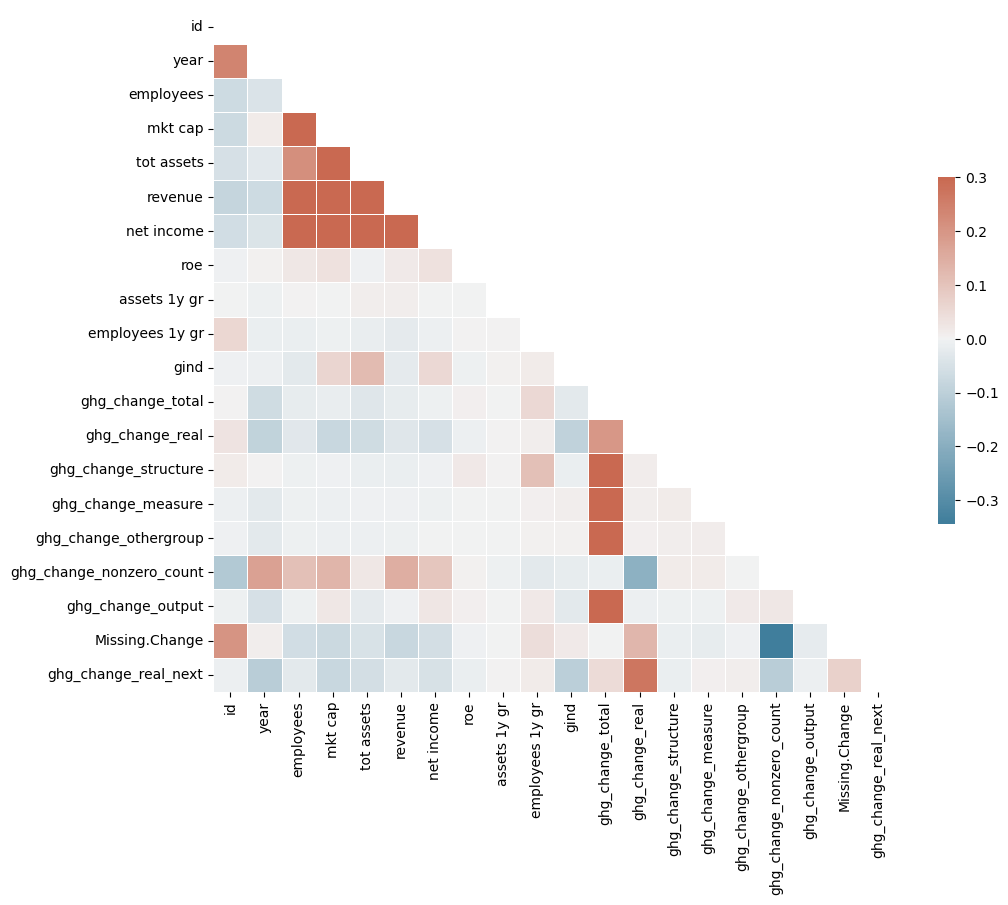

In [85]:
# Compute the correlation matrix
corr = cdp_summary.drop(columns=['companyname', 'country', 'continent']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [86]:
# recenter the year to 0 by subtracting 2011
cdp_summary['year'] = cdp_summary['year'] - 2011

In [87]:
cdp_summary

,id,year,companyname,country,employees,mkt cap,tot assets,revenue,net income,roe,...,continent,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,Missing.Change,ghg_change_real_next
0,44,0.0,3i Group,United Kingdom,530.0,4.200627e+09,9.006066e+09,8.664640e+08,2.336873e+08,6.24746,...,Europe,-11.00,-11.00,0.0,0.0,0.00,1.0,0.0,0.0,0.0
1,44,1.0,3i Group,United Kingdom,470.0,4.555430e+09,9.229143e+09,6.233958e+08,2.980762e+08,5.78988,...,Europe,-25.00,0.00,0.0,0.0,-25.00,1.0,0.0,0.0,-1.0
2,44,2.0,3i Group,United Kingdom,472.0,3.217196e+09,7.371776e+09,4.759603e+08,-1.254804e+09,-26.16979,...,Europe,-19.00,-1.00,0.0,-1.0,-17.00,3.0,0.0,0.0,0.0
3,44,3.0,3i Group,United Kingdom,358.0,4.665116e+09,6.548646e+09,5.820681e+08,2.781161e+08,6.58155,...,Europe,-29.00,0.00,0.0,0.0,-29.00,1.0,0.0,0.0,0.0
4,44,5.0,3i Group,United Kingdom,271.0,6.949796e+09,7.277030e+09,9.096287e+08,1.037036e+09,19.67951,...,Europe,-4.00,0.00,0.0,0.0,-4.00,1.0,0.0,0.0,-39.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19150,895173,11.0,Flex LNG Ltd.,Bermuda,8.0,1.190050e+09,2.572921e+09,3.381685e+08,1.597116e+08,18.61960,...,North America,59.86,49.86,0.0,0.0,10.00,2.0,0.0,0.0,NaN
19151,895420,11.0,China Everbright Greentech Limited,Hong Kong,3800.0,7.764964e+08,5.189436e+09,1.083497e+09,1.424291e+08,8.44866,...,Asia,12.55,0.00,0.0,0.0,12.55,1.0,0.0,0.0,NaN
19152,895480,11.0,Minerals Technologies Inc.,USA,3961.0,2.426912e+09,3.351200e+09,1.858300e+09,1.644000e+08,10.95963,...,North America,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,NaN
19153,895582,11.0,Sunway Berhad,Malaysia,10889.0,2.018544e+09,6.009856e+09,8.923026e+08,6.395736e+08,27.20387,...,Asia,0.97,0.97,0.0,0.0,0.00,2.0,0.0,0.0,NaN


In [88]:
cdp_summary.drop_duplicates(subset=['id', 'year'], keep='first', inplace=True)

In [89]:
# convert the gind to string based on the mapping from gics codes to Industry Group
gind_mapping = {1010: 'Energy', 1510: 'Materials', 2010: 'Capital Goods', 2020: 'Commercial \& Professional Services',
                2030: 'Transportation', 2510: 'Automobiles \& Components', 2520: 'Consumer Durables \& Apparel',
                2530: 'Consumer Services', 2550: 'Retailing', 3010: 'Consumer Staples Distribution \& Retail', 3020: 'Food, Beverage \& Tobacco',
                3030: 'Household \& Personal Products', 3510: 'Health Care Equipment \& Services', 3520: 'Pharmaceuticals, Biotechnology \& Life Sciences',
                4010: 'Banks', 4020: 'Financial Services', 4030: 'Insurance', 4510: 'Software \& Services', 4520: 'Technology Hardware \& Equipment',
                4530: 'Semiconductors \& Semiconductor Equipment', 5010: 'Telecommunication Services', 5020: 'Media \& Entertainment', 5510: 'Utilities',
                6010: 'Equity Real Estate Investment Trusts', 6020: 'Real Estate Management \& Development'}

cdp_summary['gind'] = cdp_summary['gind'].map(gind_mapping)

<>:2: SyntaxWarning: invalid escape sequence '\&'
<>:3: SyntaxWarning: invalid escape sequence '\&'
<>:3: SyntaxWarning: invalid escape sequence '\&'
<>:4: SyntaxWarning: invalid escape sequence '\&'
<>:4: SyntaxWarning: invalid escape sequence '\&'
<>:5: SyntaxWarning: invalid escape sequence '\&'
<>:5: SyntaxWarning: invalid escape sequence '\&'
<>:5: SyntaxWarning: invalid escape sequence '\&'
<>:6: SyntaxWarning: invalid escape sequence '\&'
<>:6: SyntaxWarning: invalid escape sequence '\&'
<>:7: SyntaxWarning: invalid escape sequence '\&'
<>:7: SyntaxWarning: invalid escape sequence '\&'
<>:8: SyntaxWarning: invalid escape sequence '\&'
<>:2: SyntaxWarning: invalid escape sequence '\&'
<>:3: SyntaxWarning: invalid escape sequence '\&'
<>:3: SyntaxWarning: invalid escape sequence '\&'
<>:4: SyntaxWarning: invalid escape sequence '\&'
<>:4: SyntaxWarning: invalid escape sequence '\&'
<>:5: SyntaxWarning: invalid escape sequence '\&'
<>:5: SyntaxWarning: invalid escape sequence '\&'


# taking the log of all the financial data

In [90]:
# drop rows where revenue is equal to 0 and also revenue (this is 15 rows)
cdp_summary = cdp_summary[cdp_summary['revenue'] != 0]
cdp_summary = cdp_summary[cdp_summary['employees'] != 0]

In [91]:
cdp_summary.describe()

,id,year,employees,mkt cap,tot assets,revenue,net income,roe,assets 1y gr,employees 1y gr,ghg_change_total,ghg_change_real,ghg_change_structure,ghg_change_measure,ghg_change_othergroup,ghg_change_nonzero_count,ghg_change_output,Missing.Change,ghg_change_real_next
count,18476.000000,18476.000000,1.847600e+04,1.847600e+04,1.847600e+04,1.847600e+04,1.847600e+04,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,18476.000000,15326.000000
mean,41663.032908,6.206701,3.773241e+04,1.922119e+10,6.106333e+10,1.479120e+10,1.046611e+09,16.548305,47.557961,4.378476,0.298832,-3.943038,0.879032,1.719552,0.230424,2.085137,1.412861,0.061323,-4.313538
std,142155.313880,3.514082,8.600501e+04,4.130271e+10,2.251751e+11,3.052709e+10,2.912336e+09,332.988608,5290.140162,47.015714,41.446525,7.715102,15.514248,24.568569,22.117374,1.546520,16.920171,0.239928,7.891736
min,44.000000,0.000000,3.000000e+00,2.301209e+07,3.026280e+07,1.959459e+05,-2.307369e+10,-24850.000000,-98.574410,-99.966010,-1700.000000,-49.900000,-773.760000,-356.000000,-1700.000000,0.000000,-760.000000,0.000000,-49.900000
25%,7116.750000,3.000000,4.725750e+03,2.200015e+09,3.028815e+09,1.856146e+09,7.928670e+07,5.755155,-0.386845,-2.303857,-7.700000,-5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-5.500000
50%,14827.500000,6.000000,1.350000e+04,6.537421e+09,8.781904e+09,5.180930e+09,3.016171e+08,11.257270,4.773935,1.329670,-0.449350,-1.070000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,-1.610000
75%,22142.000000,9.000000,3.705425e+04,1.849473e+10,2.865038e+10,1.460472e+10,9.961308e+08,18.599280,11.544880,6.132458,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.400000,0.000000,0.000000
max,895873.000000,11.000000,2.300000e+06,1.918191e+12,3.743567e+12,5.727540e+11,9.875686e+10,31560.000000,719066.938340,4108.910890,1010.000000,49.860000,705.200000,953.000000,896.000000,10.000000,716.000000,1.000000,45.000000


In [92]:
# winsorize the data to remove outliers do one function that takes in a list of columns and winsorizes them
def winsorize_columns(df, columns):
    for col in columns:
        df[col] = winsorize(df[col], limits=[0.001, 0.001])
    return df

# winsorize the data
cdp_summary = winsorize_columns(cdp_summary, ['employees', 'mkt cap', 'tot assets', 'revenue', 'net income', 'roe', 'assets 1y gr', 'employees 1y gr'])

# for financial data that also has negative values, take the log of the absolute value and add a sign column, you will have to use interaction terms, this will lead to interesting interpretations

# calculating Return on Assets = Net Income / Total Assets

For all the ratios, the formula i am using is $$ratio = 1 + \frac{x}{100}$$

In [93]:
# replace roe value of less than -100 with -100
cdp_summary.loc[cdp_summary['roe'] < -100, 'roe'] = -99.9

In [94]:
# convert growth rates to percentages ratios
cdp_summary['assets 1y gr'] = np.log1p((100 + cdp_summary['assets 1y gr']) / 100)
cdp_summary['employees 1y gr'] = np.log1p((100 + cdp_summary['employees 1y gr']) / 100)
cdp_summary['roe'] = np.log1p((100 + cdp_summary['roe']) / 100)

In [95]:
# net income over total assets
cdp_summary['net_income_over_assets'] = 1 + cdp_summary['net income'] / cdp_summary['tot assets']

# if net income over assets is less than 0, set it to 0
cdp_summary.loc[cdp_summary['net_income_over_assets'] < 0, 'net_income_over_assets'] = 0.001

# take the log
cdp_summary['net_income_over_assets'] = np.log1p(cdp_summary['net_income_over_assets'])

In [96]:
cdp_summary['net_income_over_assets'].describe()

count    18476.000000
mean         0.714742
std          0.035118
min          0.001000
25%          0.699439
50%          0.712307
75%          0.728312
max          1.706779
Name: net_income_over_assets, dtype: float64

In [97]:
# widnowsorize the net income over assets
cdp_summary['net_income_over_assets'] = winsorize(cdp_summary['net_income_over_assets'], limits=[0.01, 0.01])

# widnowsorize roe
cdp_summary['roe'] = winsorize(cdp_summary['roe'], limits=[0.01, 0.01])

# windowsorize the growth rates
cdp_summary['employees 1y gr'] =  winsorize(cdp_summary['employees 1y gr'], limits=[0.01, 0.01])
cdp_summary['assets 1y gr'] =  winsorize(cdp_summary['assets 1y gr'], limits=[0.01, 0.01])

In [98]:
# always positive financial variables

cdp_summary['mkt cap'] = np.log1p(cdp_summary['mkt cap'])
cdp_summary['tot assets'] = np.log1p(cdp_summary['tot assets'])
cdp_summary['revenue'] = np.log1p(cdp_summary['revenue'])
cdp_summary['employees'] = np.log1p(cdp_summary['employees'])

In [99]:
# cdp_summary['net income sign'] = (cdp_summary['net income'] < 0).astype(int)
# cdp_summary['net income'] = np.log1p(np.abs(cdp_summary['net income']))
# cdp_summary['roe sign'] = (cdp_summary['roe'] < 0).astype(int)
# cdp_summary['roe'] = np.log1p(np.abs(cdp_summary['roe']))


In [100]:
# sign(x)*log((abs(x)+1)
# cdp_summary['net income'] = np.sign(cdp_summary['net income'])*np.log1p(np.abs(cdp_summary['net income']))
# diff = cdp_summary['net income'].loc[cdp_summary['net income'] > 0].min() - cdp_summary['net income'].loc[cdp_summary['net income'] < 0].max()
# cdp_summary['net income'] = cdp_summary['net income'].apply(lambda x: x + diff if x < 0 else x)

In [101]:
# # apply a yeo-johnson transformation to the financial variables
# cdp_summary['assets 1y gr'] = power_transform(cdp_summary[['assets 1y gr']], method='yeo-johnson')
# cdp_summary['employees 1y gr'] = power_transform(cdp_summary[['employees 1y gr']], method='yeo-johnson')
# cdp_summary['net income'] = power_transform(cdp_summary[['net income']], method='yeo-johnson')
# cdp_summary['roe'] = power_transform(cdp_summary[['roe']], method='yeo-johnson')

In [102]:
# cdp_summary['assets 1y gr'] = np.log1p(cdp_summary['assets 1y gr'] + np.abs(cdp_summary['assets 1y gr'].min()))
# cdp_summary['employees 1y gr'] = np.log1p(cdp_summary['employees 1y gr'] + np.abs(cdp_summary['employees 1y gr'].min()))
# cdp_summary['net income'] = np.log1p(cdp_summary['net income'] + np.abs(cdp_summary['net income'].min()))
# cdp_summary['roe'] = np.log1p(cdp_summary['roe'] + np.abs(cdp_summary['roe'].min()))

In [103]:
cdp_summary.shape

(18476, 24)

In [104]:
# unique firm ids
len(cdp_summary['id'].unique())

3574

In [105]:
# create Industry column
cdp_summary['Industry'] = cdp_summary['gind'].str.replace(" \\&", ",")

# replace in column names underscore with space
cdp_summary.columns = cdp_summary.columns.str.replace("_", " ")

# upper case the first letter of all words in the column names
cdp_summary.columns = cdp_summary.columns.str.title()

# change mkt to market cap, tot assets to Total Assets
cdp_summary.columns = cdp_summary.columns.str.replace("Mkt Cap", "Market Cap")

In [106]:
cdp_summary

,Id,Year,Companyname,Country,Employees,Market Cap,Tot Assets,Revenue,Net Income,Roe,...,Ghg Change Real,Ghg Change Structure,Ghg Change Measure,Ghg Change Othergroup,Ghg Change Nonzero Count,Ghg Change Output,Missing.Change,Ghg Change Real Next,Net Income Over Assets,Industry
0,44,0.0,3i Group,United Kingdom,6.274762,22.158500,22.921164,20.579931,2.336873e+08,0.723907,...,-11.00,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.706038,Financial Services
1,44,1.0,3i Group,United Kingdom,6.154858,22.239586,22.945632,20.250692,2.980762e+08,0.721685,...,0.00,0.0,0.0,-25.00,1.0,0.0,0.0,-1.0,0.709167,Financial Services
2,44,2.0,3i Group,United Kingdom,6.159095,21.891776,22.720924,19.980845,-1.254804e+09,0.552909,...,-1.00,0.0,-1.0,-17.00,3.0,0.0,0.0,0.0,0.615131,Financial Services
3,44,3.0,3i Group,United Kingdom,5.883322,22.263379,22.602524,20.182098,2.781161e+08,0.725525,...,0.00,0.0,0.0,-29.00,1.0,0.0,0.0,0.0,0.714159,Financial Services
4,44,5.0,3i Group,United Kingdom,5.605802,22.661978,22.707989,20.628547,1.037036e+09,0.787000,...,0.00,0.0,0.0,-4.00,1.0,0.0,0.0,-39.7,0.761977,Financial Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19150,895173,11.0,Flex LNG Ltd.,Bermuda,2.708050,20.897261,21.668308,19.639055,1.597116e+08,0.782163,...,49.86,0.0,0.0,10.00,2.0,0.0,0.0,NaN,0.723712,Energy
19151,895420,11.0,China Everbright Greentech Limited,Hong Kong,8.243019,20.470303,22.369891,20.803459,1.424291e+08,0.734523,...,0.00,0.0,0.0,12.55,1.0,0.0,0.0,NaN,0.706777,Utilities
19152,895480,11.0,Minerals Technologies Inc.,USA,8.284504,21.609885,21.932584,21.342928,1.644000e+08,0.746497,...,0.00,0.0,0.0,0.00,0.0,0.0,0.0,NaN,0.717380,Materials
19153,895582,11.0,Sunway Berhad,Malaysia,9.295600,21.425642,22.516667,20.609316,6.395736e+08,0.820678,...,0.97,0.0,0.0,0.00,2.0,0.0,0.0,NaN,0.744990,Capital Goods


In [107]:
cdp_summary.to_csv("../../data/processed/cdp_summary_processed_v2.csv", index=False)

In [108]:
# read cdp_combined.csv
cdp_combined = pd.read_csv("../../data/combined/cdp_combined.csv")

In [109]:
# replace _ with space
cdp_combined.columns = cdp_combined.columns.str.replace("_", " ")

In [110]:
# in cdp combined, title case the column names
cdp_combined.columns = cdp_combined.columns.str.title()

In [111]:
# reset year to 0
cdp_combined['Year'] = cdp_combined['Year'] - 2011

In [112]:
cdp_combined

,Id,Year,Isin,Proportion Verified Scope1,Proportion Verified Scope2,Ghg Verification Scope1 No Data,Ghg Verification Scope1 Yes,Ghg Verification Scope2 No Data,Ghg Verification Scope2 Yes,Ghg Verification Scope3 No Data,...,Msaving Total Log1P,Investment Total Log1P,Co2 Total Log1P Missing,Msaving Total Log1P Missing,Investment Total Log1P Missing,Absent Cdp Initiative Firm Year Processed.Csv,Cdp Risk Transition,Cdp Risk Physical,Cdp Aggregated Opp,Absent Cdp Riskopp Processed.Csv
0,44,0.0,GB00B1YW4409,100.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,1.0,0
1,44,1.0,GB00B1YW4409,100.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1,0.0,0.0,1.0,0
2,44,2.0,GB00B1YW4409,100.0,100.0,0.0,1.0,0.0,1.0,0.0,...,9.831293,8.039803,0.0,0.0,0.0,0,1.0,1.0,1.0,0
3,44,3.0,GB00B1YW4409,100.0,100.0,0.0,0.0,0.0,0.0,0.0,...,11.601600,0.000000,0.0,0.0,0.0,0,1.0,1.0,1.0,0
4,44,5.0,GB00B1YW4409,100.0,100.0,0.0,1.0,0.0,1.0,0.0,...,7.273862,7.178622,0.0,0.0,0.0,0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24297,895420,11.0,KYG2R55E1030,100.0,100.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,1.0,0.0,1.0,0
24298,895480,11.0,US6031581068,100.0,100.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,1.0,0
24299,895556,11.0,US53960E1064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1,0.0,0.0,0.0,0
24300,895582,11.0,MYL5211OO007,100.0,100.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.0,0


In [113]:
# inner join cdp_summary with cdp_combined
cdp_total = cdp_summary.merge(cdp_combined, on=['Id', 'Year'], how='inner')

In [114]:
# drop columns wih _y
cdp_total = cdp_total.loc[:, ~cdp_total.columns.str.endswith('_y')]

# rename columns with _x to remove the _x
cdp_total.columns = cdp_total.columns.str.replace("_x", "")

In [115]:
# drop rows with missing values
cdp_total.dropna(subset=['Cdp Risk Transition'], inplace=True)

In [116]:
list = cdp_total.isna().mean()

In [117]:
# filter rows where ghg change real next is different between _x and _y
cdp_total.isna().mean()

Id                                               0.0
Year                                             0.0
Companyname                                      0.0
Country                                          0.0
Employees                                        0.0
                                                ... 
Absent Cdp Initiative Firm Year Processed.Csv    0.0
Cdp Risk Transition                              0.0
Cdp Risk Physical                                0.0
Cdp Aggregated Opp                               0.0
Absent Cdp Riskopp Processed.Csv                 0.0
Length: 135, dtype: float64

In [118]:
cdp_total.shape

(18289, 135)

In [119]:
# count number of rows per firm id and drop those that have less than 3 row

id_counts = cdp_total['Id'].value_counts()

id_counts = id_counts[id_counts > 3]

cdp_total = cdp_total[cdp_total['Id'].isin(id_counts.index)]

In [120]:
cdp_total.shape

(15430, 135)

In [121]:
cdp_total.isna().mean().max()

0.10946208684381076

In [122]:
# save the df to a csv file
cdp_total.to_csv("../../data/processed/cdp_total_processed_v2.csv", index=False)

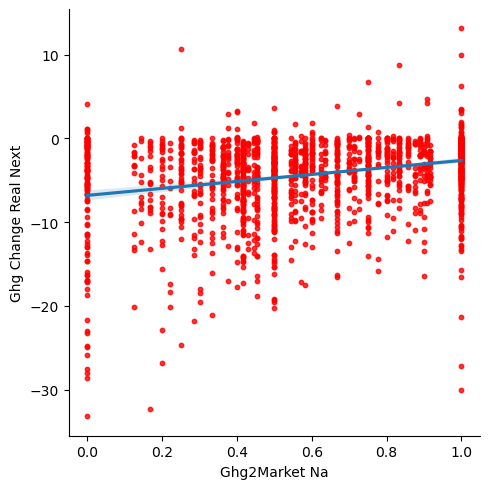

In [123]:
series = cdp_total.groupby('Id')[['Ghg Change Real Next', 'Ghg2Market Na']].mean()

# plot the two variables insert line of best fit
sns.lmplot(x='Ghg2Market Na', y='Ghg Change Real Next', data=series, fit_reg=True, scatter_kws={"s": 10, "color": "red"})

In [124]:
cdp_total['Ghg Verification Scope3 Yes']

0        0.0
1        0.0
2        1.0
3        0.0
4        1.0
        ... 
17820    1.0
17852    0.0
17853    0.0
17854    1.0
17855    1.0
Name: Ghg Verification Scope3 Yes, Length: 15430, dtype: float64

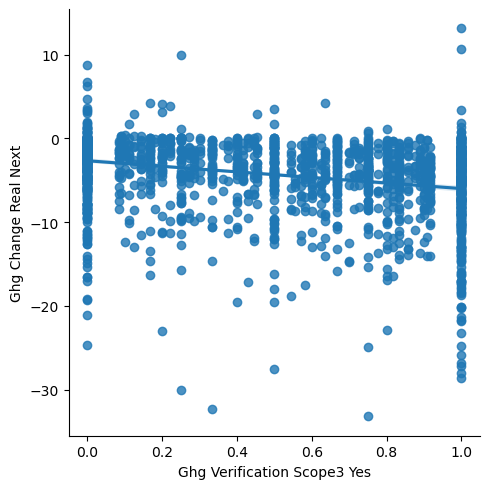

In [125]:
series = cdp_total.groupby('Id')[['Ghg Verification Scope3 Yes', 'Ghg Change Real Next']].mean()


# plot the two variables insert line of best fit
sns.lmplot(x='Ghg Verification Scope3 Yes', y='Ghg Change Real Next', data=series, fit_reg=True)

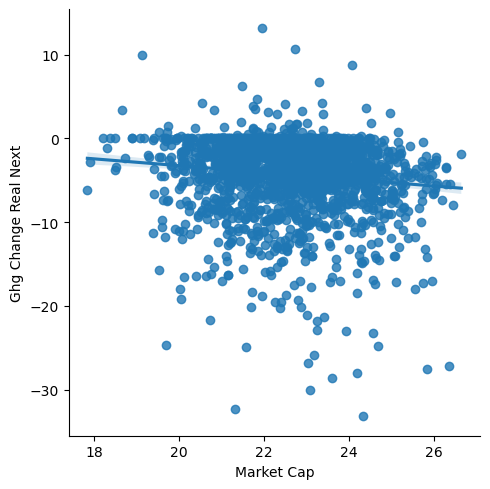

In [126]:
# do the same for Market Cap and Next Year GHG Change
series = cdp_total.groupby('Id')[['Market Cap', 'Ghg Change Real Next']].mean()

# plot the two variables insert line of best fit
sns.lmplot(x='Market Cap', y='Ghg Change Real Next', data=series, fit_reg=True)

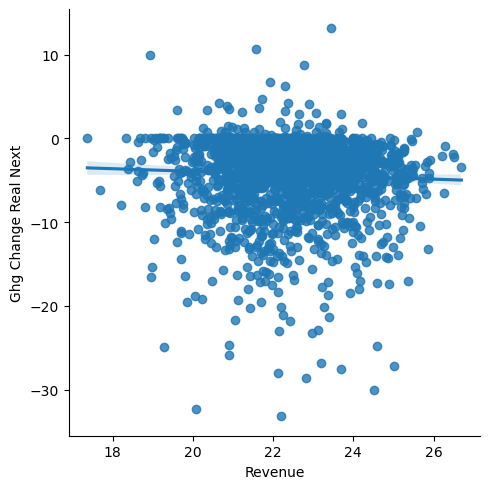

In [127]:
# do the same for Revenue and Next Year GHG Change
series = cdp_total.groupby('Id')[['Revenue', 'Ghg Change Real Next']].mean()

# plot the two variables insert line of best fit
sns.lmplot(x='Revenue', y='Ghg Change Real Next', data=series, fit_reg=True)

Revenue is positive when added to the model, mention the confounding relationship between revenue and market cap.

In [128]:
# do the same for Investment Counter
series = cdp_total.groupby('Industry')[['Investment Counter', 'Ghg Change Real Next']].mean()

# plot the two variables insert line of best fitsns.lmplot(x='Investment Counter', y='Ghg Change Real Next', data=series, fit_reg=True)

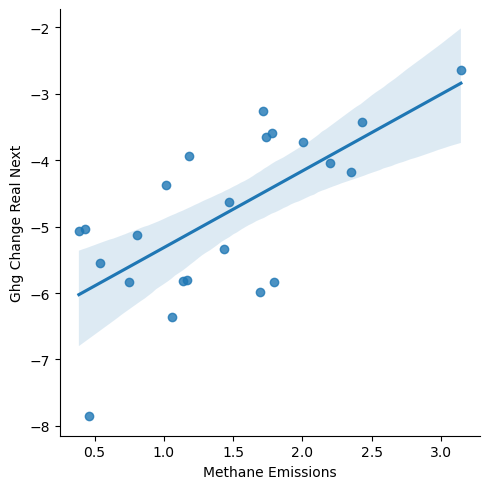

In [129]:
# do the same for methane emissions
series = cdp_total.groupby('Industry')[['Methane Emissions', 'Ghg Change Real Next']].mean()

# loc series to methane emissions less than 5
series = series.loc[series['Methane Emissions'] < 5]

# plot the two variables insert line of best fit
sns.lmplot(x='Methane Emissions', y='Ghg Change Real Next', data=series, fit_reg=True)

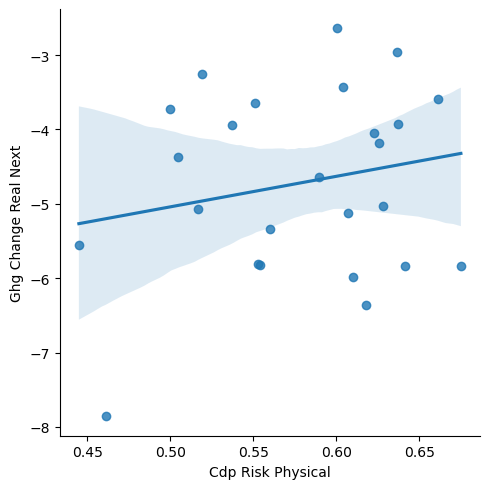

In [130]:
# do the same for Cdp Risk Physical
series = cdp_total.groupby('Industry')[['Cdp Risk Physical', 'Ghg Change Real Next']].mean()

# plot the two variables insert line of best fit
sns.lmplot(x='Cdp Risk Physical', y='Ghg Change Real Next', data=series, fit_reg=True)

In [131]:
lstm = cdp_total.dropna()

In [132]:
lstm = lstm[['Id', 'Industry', 'Continent', 'Country', 'Year', 'Employees', 'Market Cap', 'Revenue', 'Employees 1Y Gr', 
      'Assets 1Y Gr', 'Tot Assets', 'Net Income Over Assets', 'Roe', 'Ghg1', 'Ghg2Location',
      'Ghg2Market', 'Ghg2Location Na', 'Ghg2Market Na', 'Ghg3 Total Na', 'Methane Emissions', 'Type Scope1 Limited',
      'Type Scope1 Moderate', 'Type Scope1 N/A', 'Type Scope1 Third Party Underway', 'Ghg Verification Scope1 Yes',
        'Ghg Verification Scope2 Yes', 'Ghg Verification Scope3 Yes',
        'Cdp Boardoversight I', 'Cdp Incentivebinary I', 'Method Ind Macc','Method Ind Other', 'Method Ind Internal Price',
        'Method Ind Internal Incentives', 'Cdp Targetscope Percent Mean', 'Cdp Targetamount Mean',
        'Cdp Targettype Absolute', 'Cdp Targettype Intensity', 'Cdp Risk Physical', 'Cdp Risk Transition', 'Cdp Aggregated Opp', 'Investment Counter', 'Ghg Change Real', 'Ghg Change Real Next']]

In [133]:
# eexport to csv
lstm.to_csv("../../data/processed/lstm.csv", index=False)

# this is a test, not an official apollo launch please ignore :)

In [134]:
# test = cdp_summary[['id', 'year', 'continent', 'gind', 'ghg_change_real', 'ghg_change_real_next']].copy()

In [135]:
# test.dropna(inplace=True)

In [136]:
# # statsmodels mixed effects model
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# md = smf.mixedlm("ghg_change_real_next ~ year + gind + continent", test, groups=test["id"])
# mdf = md.fit()
# print(mdf.summary())

In [137]:
# # calculate r2 score
# from cgi import test
# from sklearn.metrics import r2_score

# r2_score(test['ghg_change_real_next'], mdf.fittedvalues)

In [138]:
# mdf.summary()